/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


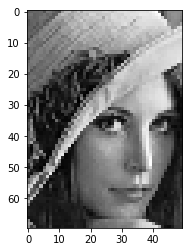

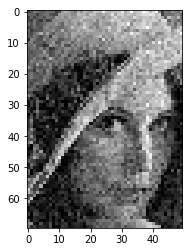

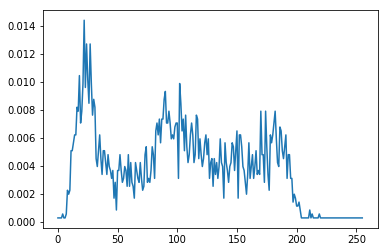

[ 90  22 168] [31.99025159  7.56490237 20.40457448] 3
[ 90  22 168] [1023.37619681   57.22774786  416.34665952] 2
[ 90  22 168] [1023.37619681   57.22774786  416.34665952] 3
[ 90  22 168] [1022.84815896   57.24951298  416.39689696] 2
[ 90  22 168] [1022.84815896   57.24951298  416.39689696] 3
[ 90  22 168] [1022.18099044   57.27707675  416.46043085] 2
[ 90  22 168] [1022.18099044   57.27707675  416.46043085] 3
[ 90  22 168] [1021.33810761   57.3120127   416.54072399] 2
[ 90  22 168] [1021.33810761   57.3120127   416.54072399] 3
[ 90  22 168] [1020.27336524   57.35634799  416.64204891] 2
[ 90  22 168] [1020.27336524   57.35634799  416.64204891] 3
[ 90  22 168] [1018.92861275   57.41272136  416.76955624] 2
[ 90  22 168] [1018.92861275   57.41272136  416.76955624] 3
[ 90  22 168] [1017.23069123   57.48462498  416.92918612] 2
[ 90  22 168] [1017.23069123   57.48462498  416.92918612] 3
[ 90  22 168] [1015.08783465   57.57680198  417.12718554] 2
[ 90  22 168] [1015.08783465   57.57680198  41

TypeError: 'NoneType' object is not iterable

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from skimage.transform import rescale, resize
import imageio
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

def read_image(name):
    image = imageio.imread(name)
    image = resize(image,(128,128))
    image = 255 * image
    image = image.astype(np.uint8)
    data = image.ravel()
    return image, data

def crop_image(image):
    image = image[30:100, 40:90]
    row_size = image.shape[0]
    col_size = image.shape[1]
    image = resize(image,(image.shape[0],image.shape[1]))
    image = 255 * image
    image = image.astype(np.uint8)
    cropped_data = image.ravel()
    return image, cropped_data, row_size, col_size

def show_image(image, row_size, col_size):
    image = np.array([image])
    image = np.reshape(image, (row_size,col_size))
    image = resize(image,(row_size,col_size))
    plt.imshow(image,cmap=cm.gray)
    plt.show()

def add_noise(data, sigma2):
    mean = 0
    gauss = np.random.normal(mean, sigma2, len(data))
    data = data + gauss
    data[data > 255] = 255
    data[data < 0] = 0
    return data

def compute_gmm(image, pixel_values):
    gmm = GaussianMixture(n_components = 256)
    gmm = gmm.fit(X=np.expand_dims(image.flatten(),1))
    gmm_x = np.array(pixel_values).reshape(-1,1)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
    plt.plot(gmm_x, gmm_y)
    plt.show

def compute_prob_x(image):
    histo = np.histogram(image.flatten(), range=(0, 255), bins = 256)
    histo[0][histo[0] < 1] = 1
    prob_x = histo[0]/np.sum(histo[0])
    plt.plot(prob_x)
    plt.show()
    return prob_x

def compute_dist_bet_pix(data):
    dist_bet_pix_vec = []
    for k in np.arange(1,len(data)):
        dist_bet_pix = np.abs(int(data[k-1])-int(data[k]))
        dist_bet_pix_vec.append(dist_bet_pix)
    dist_bet_pix_vec = np.array(dist_bet_pix_vec)
    av_dist_pix = sum(dist_bet_pix_vec)/len(dist_bet_pix_vec)
    return av_dist_pix

def initialize(data, prob_x, variance):
    K = 3
    N = len(data)
    init_mu_k = np.random.randint(0, 255, K)
    init_Sigma_k = np.random.randint(1, variance, K)
    init_pi_k = np.random.rand(K)
    init_pi_k = init_pi_k/sum(init_pi_k)
    mu_k, Sigma_k = E_step(data, init_mu_k, init_Sigma_k, init_pi_k, N, K)
    print(mu_k, Sigma_k, '1')
    return mu_k, Sigma_k
    

def E_step(data, mu_k, Sigma_k, pi_k, N, K):
    gamma = np.zeros((K, N))
    for n in range(N):
        for k in range(K):
            gamma[k,n] = pi_k[k]*norm.pdf(data[n], mu_k[k], Sigma_k[k])
    gamma /= gamma.sum(0)
    M_step(gamma, data, mu_k, Sigma_k, pi_k, N, K)
    print(mu_k, Sigma_k, '2')
    #return mu_k, Sigma_k

def M_step(gamma, data, mu_k, Sigma_k, pi_k, N, K):
    N_k = np.zeros((K))
    mu_k_old = np.copy(mu_k)
    Sigma_k_old = np.copy(Sigma_k)
    pi_k_old = np.copy(pi_k)
    for k in range(K):
        N_k[k] = np.sum(gamma[k,:])
    for k in range(K):
        mu_k[k] = 0
        for n in range(N):
            mu_k[k] += gamma[k,n]*data[n]
        mu_k[k] /= N_k[k]
    for k in range(K):
        pi_k[k] = N_k[k]/N
    for k in range(K):
        Sigma_k[k] = 0
        for n in range(N):
            Sigma_k[k] += gamma[k,n]*(data[n]-mu_k[k])**2
        Sigma_k[k] /= N_k[k]
    Sigma_k[Sigma_k < 1] = 1
    Sigma_k = np.sqrt(Sigma_k)
    check_condition(data, mu_k_old, Sigma_k_old, pi_k_old, mu_k, Sigma_k, pi_k, N, K)
    print(mu_k, Sigma_k, '3')
    #return mu_k, Sigma_k

def check_condition(data, mu_k_old, Sigma_k_old, pi_k_old, mu_k, Sigma_k, pi_k, N, K):
    old_vals = np.zeros((len(mu_k), 3))
    old_vals[:,0] = np.copy(mu_k_old)
    old_vals[:,1] = np.copy(Sigma_k_old)
    old_vals[:,2] = np.copy(pi_k_old)
    new_vals = np.zeros((len(mu_k), 3))
    new_vals[:,0] = np.copy(mu_k)
    new_vals[:,1] = np.copy(Sigma_k)
    new_vals[:,2] = np.copy(pi_k)
    matrix_vals = abs(old_vals - new_vals)
    print(mu_k, Sigma_k, end="\r")
    if len(matrix_vals[matrix_vals > 0.01].ravel()) < 1:
        return mu_k, Sigma_k
    else:
        E_step(data, mu_k, Sigma_k, pi_k, N, K)

def likelihood():
    for k in range(K):
        np.random.normal(mu_k[k], Sigma_k[k], len(data))
        histo = np.histogram(x_n_dist, range=(0, 255), bins = 256)
        prob_x_n = histo[0]/np.sum(histo[0])
        gamma_nominator = pi_k[data[n]]*prob_x_n
    
def denoised_image(chi_matrix, p_x_x_mat):
    I = np.zeros((1,chi_matrix.shape[1]))
    I[:,0] = 100
    for t in np.arange(chi_matrix.shape[1]-1, 1,-1):
        I[:,t] = np.argmax(chi_matrix[:,t-1]+p_x_x_mat[:,t])
    return I

def MSE(denoised_image, image):
    image = np.array([image])
    image = image.reshape(128,128)
    denoised_image = np.array([denoised_image])
    denoised_image = denoised_image.reshape(128,128)
    mse = ((denoised_image - image)**2).mean(axis=None)
    return mse

if __name__=="__main__":
    name="/Users/johanabrahamsson/Documents/Machine learning and data science/Python/lena_gray.jpg"
    image, data = read_image(name)
    cropped_image, cropped_data, row_size, col_size = crop_image(image)
    show_image(cropped_image, row_size, col_size)
    sigma2 = 20
    noisy_image = add_noise(cropped_data, sigma2)
    show_image(noisy_image, row_size, col_size)
    prob_x = compute_prob_x(cropped_image)
    #prob_x_noise = compute_prob_x(noisy_image)
    #variance = compute_dist_bet_pix(cropped_data)
    mu_k, Sigma_k = initialize(cropped_data, prob_x, sigma2)
    print(mu_k, Sigma_k)
    
    """"
    prob_x_ij, pixel_values = create_histogram(image)
    prob_y_ij, pixel_values = create_histogram(noisy_image)
    p_y_x_mat = create_p_y_x(noisy_image, sigma2)
    var = compute_dist_bet_pix(data)
    p_x_x_mat = create_p_x_x(data, var)
    chi_matrix = create_chi_matrix(prob_x_ij, p_y_x_mat, p_x_x_mat)
    I = denoised_image(chi_matrix, p_x_x_mat)
    show_image(I)
    mse = MSE(I, image)
    print("MSE =", mse)
    """
    


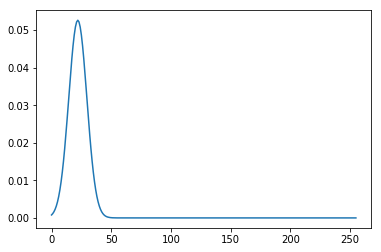

In [28]:
x = np.arange(256)
p = np.exp(-np.power(x - 22, 2.) / (2 * np.power(7.5925, 2.)))
p = p/sum(p)
plt.plot(p)
plt.show()

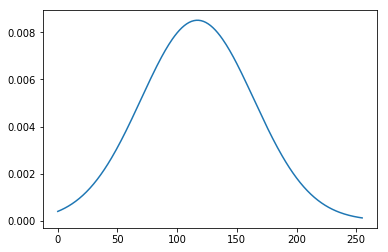

In [29]:
x = np.arange(256)
p = np.exp(-np.power(x - 117, 2.) / (2 * np.power(47.23143671, 2.)))
p = p/sum(p)
plt.plot(p)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


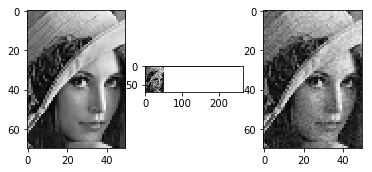

MSE = 87.26228571428571


In [52]:
def read_image(name):
    image = imageio.imread(name)
    image = resize(image,(128,128))
    image = 255 * image
    image = image.astype(np.uint8)
    data = image.ravel()
    return image, data

def crop_image(image):
    image = image[30:100, 40:90]
    row_size = image.shape[0]
    col_size = image.shape[1]
    image = resize(image,(image.shape[0],image.shape[1]))
    image = 255 * image
    image = image.astype(np.uint8)
    cropped_data = image.ravel()
    return image, cropped_data, row_size, col_size

def show_image(image_show,i, row_size, col_size):
    image_show = np.array([image_show])
    image_show = np.reshape(image_show, (row_size,col_size))
    image_show = resize(image_show,(row_size,col_size))
    plt.subplot(1,3,i)
    plt.imshow(image_show, cmap=cm.gray)
    
def add_noise(data, sigma2):
    mean = 0
    gauss = np.random.normal(mean, sigma2, len(data))
    data_noise = data + gauss
    data_noise[data_noise > 255] = 255
    data_noise[data_noise < 0] = 0
    return data_noise

def compute_prob_x(image):
    histo = np.histogram(image.flatten(), range=(0, 255), bins = 256)
    histo[0][histo[0] < 1] = 1
    prob_x = histo[0]/np.sum(histo[0])
    plt.plot(prob_x)
    #plt.show()
    return prob_x

def create_p_y_x(data, sigma2):
    p_y_x_mat = []
    for i in data:
        y_j_dist = np.random.normal(i, sigma2, len(data))
        his_y = np.histogram(y_j_dist, range=(0, 255), bins = 256)
        his_y[0][his_y[0] < 10] = 10
        prob_y_ij = his_y[0]/np.sum(his_y[0])
        p_y_x_mat.append(prob_y_ij)
    p_y_x_mat = np.array(p_y_x_mat)
    return p_y_x_mat.T

def create_p_x_x(data, pix_var):
    p_x_x_mat = []
    for i in data:
        x_j_dist = np.random.normal(i, pix_var, len(data))
        his_x = np.histogram(x_j_dist, range=(0, 255), bins = 256)
        his_x[0][his_x[0] < 10] = 10
        prob_x_ij = his_x[0]/np.sum(his_x[0])
        p_x_x_mat.append(prob_x_ij)
    p_x_x_mat = np.array(p_x_x_mat)
    return p_x_x_mat.T

def compute_dist_bet_pix(data):
    dist_bet_pix_vec = []
    for k in np.arange(1,len(data)):
        dist_bet_pix = np.abs(int(data[k-1])-int(data[k]))
        dist_bet_pix_vec.append(dist_bet_pix)
    dist_bet_pix_vec = np.array(dist_bet_pix_vec)
    av_dist_pix = sum(dist_bet_pix_vec)/len(dist_bet_pix_vec)
    return av_dist_pix
    

def create_chi_matrix(prob_x_ij, p_y_x_mat, p_x_x_mat):
    prob_x_ij = np.array(prob_x_ij)
    prob_x_ij = prob_x_ij/sum(prob_x_ij)
    chi_matrix = p_y_x_mat
    chi_matrix[:,0] = prob_x_ij*chi_matrix[:,0]
    chi_matrix[:,0] = chi_matrix[:,0]/sum(chi_matrix[:,0])
    for t in np.arange(1,chi_matrix.shape[1]):
        chi_matrix[:,t] = chi_matrix[:,t]/sum(chi_matrix[:,t])
        p_x_x_mat[:, t] = p_x_x_mat[:, t]/sum(p_x_x_mat[:, t])
        chi_matrix[:,t] = chi_matrix[:,t]*np.max(chi_matrix[:, t-1]*p_x_x_mat[:, t])
        chi_matrix[:,t] = chi_matrix[:,t]/sum(chi_matrix[:,t])
    return chi_matrix
    
def denoised_image(chi_matrix, p_x_x_mat):
    I = np.zeros((1,chi_matrix.shape[1]))
    I[:,0] = 100
    for t in np.arange(chi_matrix.shape[1]-1, 1,-1):
        I[:,t] = np.argmax(chi_matrix[:,t-1]*p_x_x_mat[:,t])
    return I

def MSE(denoised_image, image, row_size, col_size):
    image = np.array([image])
    image = image.reshape(row_size,col_size)
    denoised_image = np.array([denoised_image])
    denoised_image = denoised_image.reshape(row_size,col_size)
    mse = ((denoised_image - image)**2).mean(axis=None)
    return mse

if __name__=="__main__":
    name="/Users/johanabrahamsson/Documents/Machine learning and data science/Python/lena_gray.jpg"
    image, data = read_image(name)
    cropped_image, cropped_data, row_size, col_size = crop_image(image)
    show_image(cropped_image,1, row_size, col_size)
    sigma2 = 30
    noisy_image = add_noise(cropped_data, sigma2)
    show_image(noisy_image,2, row_size, col_size)
    prob_x = compute_prob_x(cropped_image)
    x = np.arange(256)
    p = np.exp(-np.power(x - 22, 2.) / (2 * np.power(7.5925, 2.)))
    p = p/sum(p)
    #plt.plot(p/4.2)
    r = np.exp(-np.power(x - 117, 2.) / (2 * np.power(47.23143671, 2.)))
    r = r/sum(r)
    #plt.plot(r+(p/4.2))
    distribution = r+(p/4.2)
    p_y_x_mat = create_p_y_x(noisy_image, sigma2)
    var = compute_dist_bet_pix(cropped_data)
    p_x_x_mat = create_p_x_x(cropped_data, var)
    chi_matrix = create_chi_matrix(distribution, p_y_x_mat, p_x_x_mat)
    I = denoised_image(chi_matrix, p_x_x_mat)
    show_image(I,3, row_size, col_size)
    plt.savefig('project1part3Denoise.png')
    plt.show()
    image2, data = read_image(name)
    cropped_image2, cropped_data, row_size, col_size = crop_image(image)
    mse = MSE(I, cropped_image2, row_size, col_size)
    print("MSE =", mse)

In [ ]:
r = np.exp(-np.power(x - 117, 2.) / (2 * np.power(47.23143671, 2.)))
    r = p/sum(r)
    plt.plot(r)
    plt.show()